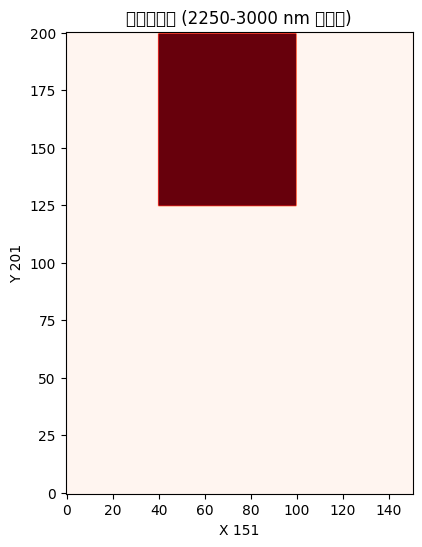

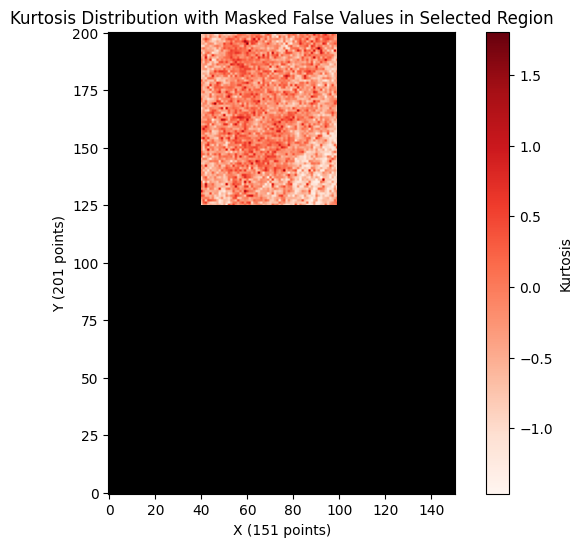

In [47]:
import numpy as np
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
from my_func.Read_ibw import read_ibw
import numpy as np
import numpy.ma as ma  # Masked array handling

# ベースライン補正
def subtract_baseline_between_two_wavelengths(wavelengths, spectrum, wavelength1, wavelength2):
    spectrum_copy = spectrum.copy()
    point1 = np.abs(wavelengths - wavelength1).argmin()
    point2 = np.abs(wavelengths - wavelength2).argmin()

    x1, x2 = wavelengths[point1], wavelengths[point2]
    y1, y2 = spectrum_copy[point1], spectrum_copy[point2]

    a = (y2 - y1) / (x2 - x1)
    b = y1 - a * x1

    for i in range(point1, point2 + 1):
        baseline = a * wavelengths[i] + b
        spectrum_copy[i] -= baseline

    return spectrum_copy

# データの読み込み
imchi3_data = read_ibw('/Users/ootahiroki/Library/CloudStorage/Box-Box/KanoLab/Raman/data/1008H38_151_201_imchi3_dataOrig.ibw')
imchi3_data = np.moveaxis(imchi3_data, 0, -1)  # 新しい形状: (151, 201, 1, 1148)

wavelengths = read_ibw('/Users/ootahiroki/Library/CloudStorage/Box-Box/KanoLab/Raman/data/1008H38_151_201_re_ramanshift2.ibw')

# マスク処理に使う波長範囲を指定
min_wavelength = 2250
max_wavelength = 3000

# 指定した波長範囲に対応するインデックスを取得
wavelength_indices = np.where((wavelengths >= min_wavelength) & (wavelengths <= max_wavelength))[0]

# 強度の総和を計算（指定した波長範囲のみ）
intensity_sum = np.sum(imchi3_data[:, :, :, wavelength_indices], axis=-1)

# 閾値に基づくマスクの作成
threshold = -100
mask = intensity_sum > threshold

# 領域の選択 (x1, x2, y1, y2の値を指定)
x1, x2 = 40, 100  # X方向の範囲
y1, y2 = 125, 200  # Y方向の範囲

# 指定された領域のみでマスクをTrueにする
mask_region = np.zeros_like(mask[:, :, 0], dtype=bool)  # 全体をFalseで初期化
mask_region[x1:x2, y1:y2] = mask[x1:x2, y1:y2, 0]  # 3次元目 (z軸) を削除して2次元に対応

# マスク結果の表示
plt.figure(figsize=(8, 6))
plt.imshow(mask_region.T, cmap='Reds', origin='lower')
plt.title(f'マスク結果 ({min_wavelength}-{max_wavelength} nm の範囲)')
plt.xlabel('X 151')
plt.ylabel('Y 201')
plt.show()


# 尖度を保存する配列を作成
kurtosis_map = np.full((imchi3_data.shape[0], imchi3_data.shape[1]), np.nan)

baseline_min_wavenumber = 1600
baseline_max_wavenumber = 1720

# ベースラインを引いた後に選択された領域内でマスクがTrueの箇所に対してのみ尖度を計算
for x in range(x1, x2):
    for y in range(y1, y2):
        if mask_region[x, y]:
            spectrum = imchi3_data[x, y, 0, :].copy()
            baseline_subtracted_spectrum = subtract_baseline_between_two_wavelengths(wavelengths, spectrum, baseline_min_wavenumber, baseline_max_wavenumber)

            range_mask = (wavelengths >= baseline_min_wavenumber) & (wavelengths <= baseline_max_wavenumber)
            spectrum_in_range = baseline_subtracted_spectrum[range_mask]
            kurt_value = kurtosis(spectrum_in_range)

            kurtosis_map[x, y] = kurt_value

masked_kurtosis_map = ma.masked_invalid(kurtosis_map)

plt.figure(figsize=(8, 6))
cmap = plt.cm.Reds
cmap.set_bad(color='black')

plt.imshow(masked_kurtosis_map.T, cmap=cmap, origin='lower')
plt.colorbar(label='Kurtosis')
plt.title('Kurtosis Distribution with Masked False Values in Selected Region')
plt.xlabel('X (151 points)')
plt.ylabel('Y (201 points)')
plt.grid(False)
plt.show()


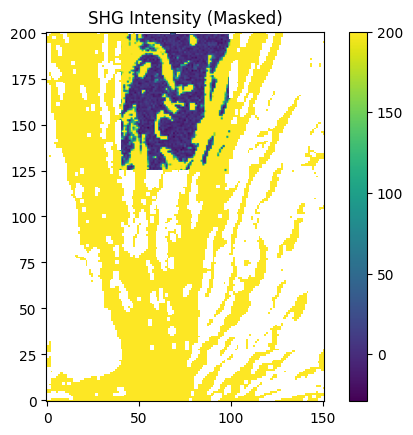

In [55]:
import igor.binarywave as bw
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma  # Masked array handling

# .ibwファイルの読み込み
def read_ibw(file_path):
    bw_data = bw.load(file_path)
    data = bw_data['wave']['wData']  # データ部分を取得
    return data

# データの可視化
def plot_data(data):
    plt.imshow(data.T, cmap='viridis', origin='lower')
    plt.colorbar()
    plt.title('SHG Intensity (Masked)')
    plt.show()

# 使用例
file_path = '/Users/ootahiroki/Library/CloudStorage/Box-Box/KanoLab/Raman/data/shg.ibw'
data = read_ibw(file_path)

# 読み取り専用のデータをコピーして新しい配列を作成
data_copy = np.copy(data)


# mask_2dがすでに1つ目のプログラムで作成されたと仮定
masked_data_copy = ma.masked_array(data_copy, mask=~mask_region)  # Falseをマスク

# データが2次元かどうかを確認
if masked_data_copy.ndim == 2:
    # SHG強度を100に制限する
    masked_data_copy[masked_data_copy > 200] = 200
    plot_data(masked_data_copy)
else:
    print(f"データは{masked_data_copy.ndim}次元で、2次元ではありません。")


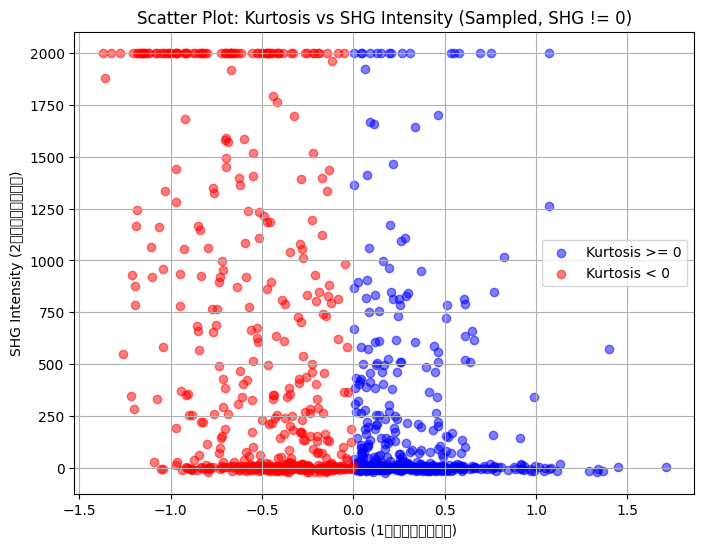

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma  # Masked array handling
import random

# .ibwファイルの読み込み
def read_ibw(file_path):
    import igor.binarywave as bw
    bw_data = bw.load(file_path)
    data = bw_data['wave']['wData']  # データ部分を取得
    return data

# データの可視化
def plot_data(data):
    plt.imshow(data.T, cmap='viridis', origin='lower')
    plt.colorbar()
    plt.title('SHG Intensity (Masked)')
    plt.show()

# 読み取り専用のデータをコピーして新しい配列を作成
file_path = '/Users/ootahiroki/Downloads/shg.ibw'
data = read_ibw(file_path)
data_copy = np.copy(data)
data_copy[data_copy > 80000] = 80000

# mask_regionがすでに作成されていると仮定
masked_data_copy = ma.masked_array(data_copy, mask=~mask_region)  # Falseをマスク

# 尖度 (kurtosis_map) と SHG Intensity の抽出
masked_kurtosis = masked_kurtosis_map.compressed()  
masked_intensity = masked_data_copy.compressed()  

# SHGが0でないデータのみをフィルタリング
non_zero_indices = np.where(masked_intensity != 0)[0]
masked_kurtosis = masked_kurtosis[non_zero_indices]
masked_intensity = masked_intensity[non_zero_indices]

# SHG強度を100に制限
masked_intensity[masked_intensity > 2000] = 2000

# 尖度が0以上と0未満のデータを抽出
positive_kurtosis_indices = np.where(masked_kurtosis >= 0)[0]
negative_kurtosis_indices = np.where(masked_kurtosis < 0)[0]


# ランダムに50個ずつサンプリング
num_samples = 500
if len(positive_kurtosis_indices) > num_samples:
    positive_samples = random.sample(list(positive_kurtosis_indices), num_samples)
else:
    positive_samples = list(positive_kurtosis_indices)

if len(negative_kurtosis_indices) > num_samples:
    negative_samples = random.sample(list(negative_kurtosis_indices), num_samples)
else:
    negative_samples = list(negative_kurtosis_indices)

# サンプリングされたデータを取得
positive_kurtosis_values = masked_kurtosis[positive_samples]
positive_intensity_values = masked_intensity[positive_samples]

negative_kurtosis_values = masked_kurtosis[negative_samples]
negative_intensity_values = masked_intensity[negative_samples]

# プロットの作成
plt.figure(figsize=(8, 6))

# 尖度が0以上のデータを青でプロット
plt.scatter(positive_kurtosis_values, positive_intensity_values, c='blue', alpha=0.5, label='Kurtosis >= 0')

# 尖度が0未満のデータを赤でプロット
plt.scatter(negative_kurtosis_values, negative_intensity_values, c='red', alpha=0.5, label='Kurtosis < 0')

plt.title('Scatter Plot: Kurtosis vs SHG Intensity (Sampled, SHG != 0)')
plt.xlabel('Kurtosis (1つ目のプログラム)')
plt.ylabel('SHG Intensity (2つ目のプログラム)')
plt.legend()
plt.grid(True)
plt.show()
